In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
import pickle as pkl
import time
import os
import tensorflow_hub as hub
from tensorflow.errors import InvalidArgumentError

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/3'
embed = hub.Module(module_url)

Using TensorFlow backend.


AttributeError: module 'tensorflow' has no attribute 'name_scope'

In [2]:
class_mapping = {}
with open('dbpedia_csv/classes.txt') as txt_file:
    line_num = 0
    for line in txt_file:
        class_mapping[line_num] = line.strip()
        line_num+=1
        
print(class_mapping)

FileNotFoundError: [Errno 2] No such file or directory: 'dbpedia_csv/classes.txt'

In [3]:
class USEDataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size = 32, n_classes=14, shuffle=True):
        self.dim = (1,)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index:(index+1)]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X,y = self.__data_generation(list_IDs_temp)
        return X,y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        X = []
        y = np.empty((self.batch_size), dtype = int)
        for item in list_IDs_temp:
            Xarray = pkl.load(open('Training/'+item, 'rb'))
        for i, row in enumerate(Xarray[1]):
            X.append(' '.join(row))
            y[i] = Xarray[0]-1
        X = np.array(X,dtype = object)[:,np.newaxis]
        
        return X, keras.utils.to_categorical(y, num_classes = self.n_classes)

In [4]:
params = {'batch_size':32, 'n_classes':14,'shuffle':True}
partition, labels = pkl.load(open('Training/Metadata', 'rb'))
for key in labels.keys():
    labels[key] -= 1
training_generator = USEDataGenerator(partition['train'], **params)

In [5]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)),signature='default', as_dict=True)['default']

In [6]:
input_text = keras.layers.Input(shape=(1,), dtype = tf.string)
embedding = keras.layers.Lambda(UniversalEmbedding, output_shape = (512, ))(input_text)
dense = keras.layers.Dense(256, activation='relu')(embedding)
pred = keras.layers.Dense(14, activation = 'softmax')(dense)
model = keras.models.Model(inputs = [input_text], outputs = pred)
model.compile(loss= 'categorical_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])

model.name = 'USE_model'

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit_generator(generator = training_generator, epochs = 1, verbose = 1)
    model.save_weights('./'+model.name+'.h5')
    start = time.time()
    accuracies = {}
    for label in os.listdir('Testing'):
        accuracies[label] = {}
        for sent_len in os.listdir('Testing/{}'.format(label)):
            Xtest = []
            labels = []
            if int(sent_len) < 100:
                for file in os.listdir('Testing/{}/{}'.format(label, sent_len)):
                    sample = pkl.load(open('Testing/{}/{}/{}'.format(label, sent_len, file),'rb'))
                    labels.append(sample[0])
                    Xtest.append(' '.join(sample[1]))
                Xtest = np.array(Xtest, dtype = object)[:,np.newaxis]
                result = np.asarray(model.predict(Xtest))
                result = np.argmax(result, axis = 1)+1
                accuracy = np.sum(result == labels)/len(labels)
                print('{}, sentence_length:{}, Accuracy:{}'.format(label, sent_len,accuracy))
                accuracies[label][sent_len] = accuracy
                print('elapsed time: {}'.format((time.time()-start)/60))
        pkl.dump(accuracies, open('USEaccuracy', 'wb'))

Epoch 1/1
24225/24225 [==============================] - 14402s 594ms/step - loss: 0.3324 - acc: 0.8885
Class9, sentence_length:27, Accuracy:0.9973411326774794
elapsed time: 1.1906596740086874
Class9, sentence_length:74, Accuracy:0.9861111111111112
elapsed time: 1.3879637757937113
Class9, sentence_length:73, Accuracy:0.9869451697127938
elapsed time: 1.595775059858958
Class9, sentence_length:15, Accuracy:0.9952779566430564
elapsed time: 2.661835833390554
Class9, sentence_length:2, Accuracy:0.6506
elapsed time: 3.4307888110478717
Class9, sentence_length:16, Accuracy:0.9966799468791501
elapsed time: 4.482570544878642
Class9, sentence_length:10, Accuracy:0.9835043250854959
elapsed time: 5.4840564131736755
Class9, sentence_length:31, Accuracy:0.9980827170638181
elapsed time: 6.640373675028483
Class9, sentence_length:50, Accuracy:0.9972572682391662
elapsed time: 7.382950397332509
Class9, sentence_length:47, Accuracy:0.9986400725294651
elapsed time: 8.24403664668401


InvalidArgumentError: input must be a vector, got shape: []
	 [[Node: lambda_1/module_apply_default/text_preprocessor/tokenize/StringSplit = StringSplit[skip_empty=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](lambda_1/module_apply_default/text_preprocessor/RegexReplace_1, lambda_1/module_apply_default/text_preprocessor/tokenize/Const)]]

In [12]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./'+model.name+'.h5')  
    accuracies = pkl.load(open('USEaccuracy', 'rb'))
    start = time.time()
    for label in os.listdir('Testing'):
        if label not in accuracies.keys():
            accuracies[label] = {}
        for sent_len in os.listdir('Testing/{}'.format(label)):
            if sent_len not in accuracies[label].keys():
                Xtest = []
                labels = []
                if int(sent_len) < 100:
                    for file in os.listdir('Testing/{}/{}'.format(label, sent_len)):
                        sample = pkl.load(open('Testing/{}/{}/{}'.format(label, sent_len, file),'rb'))
                        labels.append(sample[0])
                        Xtest.append(' '.join(sample[1]))
                    Xtest = np.array(Xtest, dtype = object)[:,np.newaxis]
                    try:
                        result = np.asarray(model.predict(Xtest))
                        result = np.argmax(result, axis = 1)+1
                        accuracy = np.sum(result == labels)/len(labels)
                        print('{}, sentence_length:{}, Accuracy:{}'.format(label, sent_len,accuracy))
                        accuracies[label][sent_len] = accuracy
                    except InvalidArgumentError:
                        print("Error with {} Sentence Length: {}".format(label, sent_len))
                        pass
                    print('elapsed time: {}'.format((time.time()-start)/60))
            pkl.dump(accuracies, open('USEaccuracy', 'wb'))

Error with Class10 Sentence Length: 16
elapsed time: 0.5226009408632915
Class10, sentence_length:10, Accuracy:0.9345057610673135
elapsed time: 0.952877676486969
Class10, sentence_length:31, Accuracy:0.9513826940231935
elapsed time: 1.6771594723065695
Class10, sentence_length:50, Accuracy:0.9371647509578545
elapsed time: 2.228586792945862
Class10, sentence_length:47, Accuracy:0.9429763560500696
elapsed time: 2.817718724409739
Class10, sentence_length:97, Accuracy:1.0
elapsed time: 2.839200135072072
Class10, sentence_length:14, Accuracy:0.9564721969006381
elapsed time: 3.8203306833902997
Class10, sentence_length:48, Accuracy:0.940128296507484
elapsed time: 4.394586046536763
Class10, sentence_length:79, Accuracy:0.923728813559322
elapsed time: 4.600980269908905
Class10, sentence_length:90, Accuracy:0.922077922077922
elapsed time: 4.654197450478872
Class10, sentence_length:12, Accuracy:0.9477138481732662
elapsed time: 5.657459588845571
Class10, sentence_length:69, Accuracy:0.92526158445440

Class8, sentence_length:74, Accuracy:0.9672977624784854
elapsed time: 50.99090158144633
Class8, sentence_length:73, Accuracy:0.967795210569777
elapsed time: 51.66182171106338
Class8, sentence_length:15, Accuracy:0.9404322614654718
elapsed time: 52.499824758370714
Class8, sentence_length:2, Accuracy:0.5718
elapsed time: 53.348491207758585
Class8, sentence_length:16, Accuracy:0.9451054624121147
elapsed time: 54.28773275613785
Class8, sentence_length:10, Accuracy:0.9172311600338696
elapsed time: 55.286707099278765
Class8, sentence_length:31, Accuracy:0.9645107794361526
elapsed time: 56.26304870049159
Class8, sentence_length:50, Accuracy:0.9732977303070761
elapsed time: 57.20610346794128
Class8, sentence_length:47, Accuracy:0.9750528541226215
elapsed time: 58.237097982565565
Error with Class8 Sentence Length: 97
elapsed time: 58.28260423342387
Class8, sentence_length:14, Accuracy:0.9371896722939425
elapsed time: 59.200002264976504
Class8, sentence_length:48, Accuracy:0.975504941985389
elap

Class8, sentence_length:43, Accuracy:0.9742370194213238
elapsed time: 123.42301350037256
Class8, sentence_length:9, Accuracy:0.901656314699793
elapsed time: 124.40934317509333
Class7, sentence_length:27, Accuracy:0.963019693654267
elapsed time: 125.96133774518967
Class7, sentence_length:74, Accuracy:0.9779735682819384
elapsed time: 126.88781266609827
Class7, sentence_length:73, Accuracy:0.9777777777777777
elapsed time: 127.84218296607335
Class7, sentence_length:15, Accuracy:0.9440829605530704
elapsed time: 129.06526328722637
Class7, sentence_length:2, Accuracy:0.436
elapsed time: 129.83974316120148
Class7, sentence_length:16, Accuracy:0.9471967380224261
elapsed time: 130.97368922630946
Class7, sentence_length:10, Accuracy:0.9105527638190954
elapsed time: 131.9887863636017
Class7, sentence_length:31, Accuracy:0.9642614793033251
elapsed time: 133.42809418439865
Class7, sentence_length:50, Accuracy:0.96999422965955
elapsed time: 134.96810043255488
Class7, sentence_length:47, Accuracy:0.96

Class7, sentence_length:19, Accuracy:0.9558398679323153
elapsed time: 221.0060930887858
Class7, sentence_length:70, Accuracy:0.9755489021956087
elapsed time: 222.09030544757843
Class7, sentence_length:36, Accuracy:0.9678657074340528
elapsed time: 223.5493309656779
Class7, sentence_length:67, Accuracy:0.9763603925066905
elapsed time: 224.7739830295245
Class7, sentence_length:43, Accuracy:0.9702272133716375
elapsed time: 226.2654623945554
Class7, sentence_length:9, Accuracy:0.9021804360872174
elapsed time: 227.34262255032857
Class3, sentence_length:27, Accuracy:0.9489351403678606
elapsed time: 228.70753314495087
Class3, sentence_length:74, Accuracy:0.9769585253456221
elapsed time: 229.45450311104457
Class3, sentence_length:73, Accuracy:0.9738372093023255
elapsed time: 230.2164906581243
Class3, sentence_length:15, Accuracy:0.7501038637307852
elapsed time: 231.34466263453166
Class3, sentence_length:2, Accuracy:0.2518
elapsed time: 232.12760534683864
Error with Class3 Sentence Length: 16
el

Class3, sentence_length:35, Accuracy:0.9637661268185561
elapsed time: 305.6443827430407
Class3, sentence_length:32, Accuracy:0.9593114241001565
elapsed time: 306.9492725133896
Class3, sentence_length:46, Accuracy:0.9689358889623265
elapsed time: 308.1421666741371
Class3, sentence_length:71, Accuracy:0.9736495388669302
elapsed time: 308.9824241836866
Class3, sentence_length:85, Accuracy:0.9846491228070176
elapsed time: 309.2688723007838
Class3, sentence_length:19, Accuracy:0.8847324923879948
elapsed time: 310.4090376973152
Class3, sentence_length:70, Accuracy:0.970886075949367
elapsed time: 311.2867254813512
Class3, sentence_length:36, Accuracy:0.9657667687169497
elapsed time: 312.4970703403155
Class3, sentence_length:67, Accuracy:0.9734366353071389
elapsed time: 313.4343403895696
Class3, sentence_length:43, Accuracy:0.9696875
elapsed time: 314.7060983578364
Class3, sentence_length:9, Accuracy:0.4496684749849307
elapsed time: 315.7464948415756
Class6, sentence_length:27, Accuracy:0.9903

Class6, sentence_length:8, Accuracy:0.9082
elapsed time: 402.38102509578067
Class6, sentence_length:5, Accuracy:0.818
elapsed time: 403.3668906331062
Class6, sentence_length:35, Accuracy:0.9905660377358491
elapsed time: 404.7711638092995
Class6, sentence_length:32, Accuracy:0.9900071377587437
elapsed time: 406.1097782452901
Class6, sentence_length:46, Accuracy:0.9918864097363083
elapsed time: 407.49524470965065
Class6, sentence_length:71, Accuracy:0.9945593035908596
elapsed time: 408.4921066125234
Class6, sentence_length:85, Accuracy:0.996742671009772
elapsed time: 408.87301070690154
Class6, sentence_length:19, Accuracy:0.9859213250517599
elapsed time: 410.0839383006096
Class6, sentence_length:70, Accuracy:0.9942618675013041
elapsed time: 411.1448878010114
Class6, sentence_length:36, Accuracy:0.9906965049031934
elapsed time: 412.61535262266796
Class6, sentence_length:67, Accuracy:0.9929939280709948
elapsed time: 413.75644282897315
Class6, sentence_length:43, Accuracy:0.9922715981231024

Class12, sentence_length:21, Accuracy:0.989262051633539
elapsed time: 486.2509178439776
Class12, sentence_length:18, Accuracy:0.9847991313789359
elapsed time: 487.40188347498577
Class12, sentence_length:98, Accuracy:1.0
elapsed time: 487.4392052769661
Class12, sentence_length:29, Accuracy:0.9912536443148688
elapsed time: 488.57102456490196
Class12, sentence_length:8, Accuracy:0.9059623849539816
elapsed time: 489.55794028838477
Class12, sentence_length:5, Accuracy:0.7789557911582317
elapsed time: 490.4290225704511
Class12, sentence_length:35, Accuracy:0.9920447849145551
elapsed time: 491.5919758717219
Class12, sentence_length:32, Accuracy:0.9918812989921613
elapsed time: 492.7611456990242
Class12, sentence_length:46, Accuracy:0.9905109489051095
elapsed time: 493.85675735870996
Class12, sentence_length:71, Accuracy:0.9871794871794872
elapsed time: 494.64202588796616
Class12, sentence_length:85, Accuracy:0.9925788497217068
elapsed time: 494.978511929512
Class12, sentence_length:19, Accura

Class5, sentence_length:34, Accuracy:0.9780358495329462
elapsed time: 573.0259935220082
Class5, sentence_length:83, Accuracy:0.9747747747747748
elapsed time: 573.3619733214379
Class5, sentence_length:65, Accuracy:0.9799588900308325
elapsed time: 574.4104660868645
Class5, sentence_length:21, Accuracy:0.9488421052631579
elapsed time: 575.7233765920004
Class5, sentence_length:18, Accuracy:0.9203867516971816
elapsed time: 576.9377098083496
Class5, sentence_length:98, Accuracy:0.9473684210526315
elapsed time: 576.9520327647527
Class5, sentence_length:29, Accuracy:0.9725645198790979
elapsed time: 578.2871486902237
Class5, sentence_length:8, Accuracy:0.5736589271417134
elapsed time: 579.2403403162956
Class5, sentence_length:5, Accuracy:0.47649529905981197
elapsed time: 580.1312729914983
Class5, sentence_length:35, Accuracy:0.9778064516129032
elapsed time: 581.4694040536881
Class5, sentence_length:32, Accuracy:0.9768292682926829
elapsed time: 582.8270807623863
Class5, sentence_length:46, Accur

Class2, sentence_length:75, Accuracy:0.9772951628825272
elapsed time: 658.4362634420395
Class2, sentence_length:39, Accuracy:0.9731580388934539
elapsed time: 659.8095683574677
Class2, sentence_length:81, Accuracy:0.9806949806949807
elapsed time: 660.1205952207248
Class2, sentence_length:58, Accuracy:0.9754064193413923
elapsed time: 661.2497998396556
Class2, sentence_length:34, Accuracy:0.9735049205147616
elapsed time: 662.5509084502856
Class2, sentence_length:83, Accuracy:0.983739837398374
elapsed time: 662.7753069798151
Class2, sentence_length:65, Accuracy:0.9798241076047595
elapsed time: 663.7673186182976
Class2, sentence_length:21, Accuracy:0.9691318327974277
elapsed time: 664.9519792000452
Class2, sentence_length:18, Accuracy:0.9677687668954045
elapsed time: 666.095316696167
Class2, sentence_length:98, Accuracy:0.9583333333333334
elapsed time: 666.1126309156418
Class2, sentence_length:29, Accuracy:0.9750705550329257
elapsed time: 667.5025972962379
Class2, sentence_length:8, Accurac

Class14, sentence_length:59, Accuracy:0.9677141627206199
elapsed time: 745.4750795125962
Class14, sentence_length:3, Accuracy:0.3488
elapsed time: 746.303165213267
Class14, sentence_length:66, Accuracy:0.9668539325842697
elapsed time: 747.229854118824
Class14, sentence_length:23, Accuracy:0.9636163175303197
elapsed time: 748.5510325153668
Class14, sentence_length:75, Accuracy:0.9511737089201878
elapsed time: 749.1523412585259
Class14, sentence_length:39, Accuracy:0.9741189427312775
elapsed time: 750.528877611955
Class14, sentence_length:81, Accuracy:0.9465408805031447
elapsed time: 750.9120523929596
Class14, sentence_length:58, Accuracy:0.9678631051752922
elapsed time: 752.0489498217901
Class14, sentence_length:34, Accuracy:0.9707602339181286
elapsed time: 753.3754743417104
Class14, sentence_length:83, Accuracy:0.945631067961165
elapsed time: 753.6941958785058
Class14, sentence_length:65, Accuracy:0.9644204851752022
elapsed time: 754.6504322926204
Class14, sentence_length:21, Accuracy:

Class13, sentence_length:89, Accuracy:0.950920245398773
elapsed time: 824.1056114713351
Class13, sentence_length:63, Accuracy:0.9500924214417745
elapsed time: 824.9562794884046
Class13, sentence_length:49, Accuracy:0.959674134419552
elapsed time: 825.9837881922722
Error with Class13 Sentence Length: 60
elapsed time: 826.8537021517753
Class13, sentence_length:88, Accuracy:0.9538461538461539
elapsed time: 826.9800719102224
Class13, sentence_length:59, Accuracy:0.9510752688172043
elapsed time: 827.9009239474932
Class13, sentence_length:3, Accuracy:0.2172
elapsed time: 828.7134146094322
Class13, sentence_length:66, Accuracy:0.9512874043145442
elapsed time: 829.4692003965378
Class13, sentence_length:23, Accuracy:0.9551707779886148
elapsed time: 830.5843838612238
Class13, sentence_length:75, Accuracy:0.9544950055493896
elapsed time: 831.098034842809
Class13, sentence_length:39, Accuracy:0.9662379421221865
elapsed time: 832.2613290905953
Class13, sentence_length:81, Accuracy:0.954465849387040

Class11, sentence_length:64, Accuracy:0.9924605894448252
elapsed time: 895.2585479418436
Class11, sentence_length:24, Accuracy:0.96875
elapsed time: 896.1546200871468
Class11, sentence_length:89, Accuracy:0.9935064935064936
elapsed time: 896.2545367240906
Class11, sentence_length:63, Accuracy:0.9905977165883143
elapsed time: 897.011399992307
Class11, sentence_length:49, Accuracy:0.987987987987988
elapsed time: 897.8419247229893
Class11, sentence_length:60, Accuracy:0.9912390488110138
elapsed time: 898.6599325338999
Class11, sentence_length:88, Accuracy:0.9944444444444445
elapsed time: 898.7748928626378
Class11, sentence_length:59, Accuracy:0.9920440636474909
elapsed time: 899.5654413898786
Class11, sentence_length:3, Accuracy:0.3974
elapsed time: 900.4852124770482
Class11, sentence_length:66, Accuracy:0.9919472913616398
elapsed time: 901.2090827941895
Class11, sentence_length:23, Accuracy:0.96759941089838
elapsed time: 902.1213383396466
Class11, sentence_length:75, Accuracy:0.991507430

Class4, sentence_length:80, Accuracy:0.9984962406015038
elapsed time: 967.5290224949518
Class4, sentence_length:4, Accuracy:0.625375225135081
elapsed time: 968.37406762441
Class4, sentence_length:11, Accuracy:0.7800963081861958
elapsed time: 969.3914925734202
Class4, sentence_length:64, Accuracy:0.996185632549269
elapsed time: 970.1804409146309
Class4, sentence_length:24, Accuracy:0.9833561331509348
elapsed time: 971.3835136731466
Class4, sentence_length:89, Accuracy:1.0
elapsed time: 971.513535674413
Class4, sentence_length:63, Accuracy:0.9963122311001844
elapsed time: 972.3493509570758
Class4, sentence_length:49, Accuracy:0.9961815867628341
elapsed time: 973.3253852009773
Class4, sentence_length:60, Accuracy:0.9966024915062288
elapsed time: 974.1633299152056
Class4, sentence_length:88, Accuracy:1.0
elapsed time: 974.3190570553144
Class4, sentence_length:59, Accuracy:0.9972406181015453
elapsed time: 975.1900346875191
Class4, sentence_length:3, Accuracy:0.5636
elapsed time: 976.0732983

Class1, sentence_length:41, Accuracy:0.93008356545961
elapsed time: 1050.3516546607018
Class1, sentence_length:82, Accuracy:0.8647058823529412
elapsed time: 1050.5588923573494
Class1, sentence_length:1, Accuracy:0.1654
elapsed time: 1051.1582018176714
Class1, sentence_length:91, Accuracy:0.84375
elapsed time: 1051.2019250909486
Class1, sentence_length:80, Accuracy:0.8728448275862069
elapsed time: 1051.4793240825336
Class1, sentence_length:4, Accuracy:0.6145229045809162
elapsed time: 1052.319527375698
Class1, sentence_length:11, Accuracy:0.8841745425296602
elapsed time: 1053.367608543237
Class1, sentence_length:64, Accuracy:0.9138477801268499
elapsed time: 1054.363520224889
Class1, sentence_length:24, Accuracy:0.9326334208223972
elapsed time: 1055.6205794056257
Class1, sentence_length:89, Accuracy:0.8111111111111111
elapsed time: 1055.6796920100849
Class1, sentence_length:63, Accuracy:0.916243654822335
elapsed time: 1056.6840933362644
Class1, sentence_length:49, Accuracy:0.9286182056319

In [29]:
for item in accuracies.keys():
    print(len(accuracies[item]))
    for i in range(len(accuracies[item])):
        if np.isnan(accuracies[item][i]):
            if i == 0:
                accuracies[item][i] == accuracies[item][i+1]
            if i == len(accuracies[item])-1:
                accuracies[item][i] == accuracies[item][i-1]
            else:
                accuracies[item][i] = (accuracies[item][i-1]+accuracies[item][i+1])/2
            
accuracies

99
99
99
99
99
99
99
99
99
99


/home/alon/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


99
99
99
99
99
99


,Company,EducationalInstitution,Artist,Athlete,OfficeHolder,MeanOfTransportation,Building,NaturalPlace,Village,Animal,Plant,Album,Film,WrittenWork,Total Accuracy,Number of Words
1,0.364200,0.093200,0.221800,0.470000,0.458200,0.015400,0.125800,0.216000,0.864200,0.192400,0.165400,0.058000,0.105200,0.801800,0.296543,1
2,0.400600,0.571800,0.495800,0.619200,0.562400,0.217800,0.155600,0.373800,0.650600,0.251800,0.437000,0.436000,0.272200,0.630000,0.433900,2
3,0.466400,0.658400,0.743600,0.563600,0.621800,0.629000,0.217200,0.397400,0.631000,0.312400,0.516600,0.608600,0.348800,0.737400,0.532300,3
4,0.476295,0.751200,0.867147,0.625375,0.709742,0.681600,0.329400,0.444800,0.867200,0.314652,0.614523,0.722200,0.393200,0.778000,0.612524,4
5,0.476495,0.818200,0.909364,0.730038,0.778956,0.814000,0.433200,0.478096,0.773200,0.339472,0.691491,0.798000,0.464000,0.818000,0.665894,5
6,0.505904,0.849000,0.927971,0.763858,0.833367,0.812800,0.573800,0.620724,0.764200,0.387510,0.740456,0.832000,0.550200,0.853600,0.662495,6
7,0.544126,0.879600,0.934761,0.761562,0.879376,0.871400,0.684284,0.828366,0.943600,0.431545,0.789421,0.867000,0.651000,0.880000,0.781860,7
8,0.573659,0.894768,0.942966,0.771171,0.905962,0.894695,0.754010,0.860666,0.961365,0.437224,0.822645,0.883000,0.717544,0.908200,0.740465,8
9,0.593305,0.901656,0.950370,0.783811,0.924100,0.917571,0.794779,0.871671,0.979129,0.449668,0.845198,0.902180,0.768683,0.926385,0.708266,9
10,0.614151,0.917231,0.955173,0.777176,0.942238,0.934506,0.821465,0.885524,0.983504,0.496773,0.863308,0.910553,0.819823,0.944367,0.847557,10


In [24]:
print(accuracies['Company'][26])

nan


In [46]:
def impute_missing(accuracies, item, i):
    if i == 0:
        return(accuracies[item][i+1])
    if i == len(accuracies[item])-1:
        return(accuracies[item][i-3])
    else:
        if np.isnan(accuracies[item][i-1]):
            accuracies[item][i-1] = impute_missing(accuracies,item,i-1)
        if np.isnan(accuracies[item][i+1]):
            accuracies[item][i+1] = impute_missing(accuracies,item,i+1)
        return((accuracies[item][i-1]+accuracies[item][i+1])/2)

In [47]:
accs = pkl.load(open('USEaccuracy', 'rb'))
accuracies = pd.DataFrame([accs[key] for key in accs.keys()]).rename(index = class_mapping)
accuracies = accuracies.reindex(sorted(list(accuracies.columns),key = int), axis = 1).transpose()

def fill_missing(accuracies):
    for item in accuracies.keys():
        print(len(accuracies[item]))
        for i in range(len(accuracies[item])):
            if np.isnan(accuracies[item][i]):
                if i> len(accuracies[item])-5:
                    accuracies[item][i] = accuracies[item][i-1]
                else:
                    accuracies[item][i] = impute_missing(accuracies, item, i)

accuracies['Total Accuracy'] = accuracies.sum(axis=1)/14
accuracies['Number of Words'] = accuracies.index.astype(int)
accuracies

99
99
99
99
99
99
99
99
99
99
99
99
99
99


,Company,EducationalInstitution,Artist,Athlete,OfficeHolder,MeanOfTransportation,Building,NaturalPlace,Village,Animal,Plant,Album,Film,WrittenWork,Total Accuracy,Number of Words
1,0.364200,0.093200,0.221800,0.470000,0.458200,0.015400,0.125800,0.216000,0.864200,0.192400,0.165400,0.058000,0.105200,0.801800,0.296543,1
2,0.400600,0.571800,0.495800,0.619200,0.562400,0.217800,0.155600,0.373800,0.650600,0.251800,0.437000,0.436000,0.272200,0.630000,0.433900,2
3,0.466400,0.658400,0.743600,0.563600,0.621800,0.629000,0.217200,0.397400,0.631000,0.312400,0.516600,0.608600,0.348800,0.737400,0.532300,3
4,0.476295,0.751200,0.867147,0.625375,0.709742,0.681600,0.329400,0.444800,0.867200,0.314652,0.614523,0.722200,0.393200,0.778000,0.612524,4
5,0.476495,0.818200,0.909364,0.730038,0.778956,0.814000,0.433200,0.478096,0.773200,0.339472,0.691491,0.798000,0.464000,0.818000,0.665894,5
6,0.505904,0.849000,0.927971,0.763858,0.833367,0.812800,0.573800,0.620724,0.764200,0.387510,0.740456,0.832000,0.550200,0.853600,0.715385,6
7,0.544126,0.879600,0.934761,0.761562,0.879376,0.871400,0.684284,0.828366,0.943600,0.431545,0.789421,0.867000,0.651000,0.880000,0.781860,7
8,0.573659,0.894768,0.942966,0.771171,0.905962,0.894695,0.754010,0.860666,0.961365,0.437224,0.822645,0.883000,0.717544,0.908200,0.809134,8
9,0.593305,0.901656,0.950370,0.783811,0.924100,0.917571,0.794779,0.871671,0.979129,0.449668,0.845198,0.902180,0.768683,0.926385,0.829179,9
10,0.614151,0.917231,0.955173,0.777176,0.942238,0.934506,0.821465,0.885524,0.983504,0.496773,0.863308,0.910553,0.819823,0.944367,0.847557,10


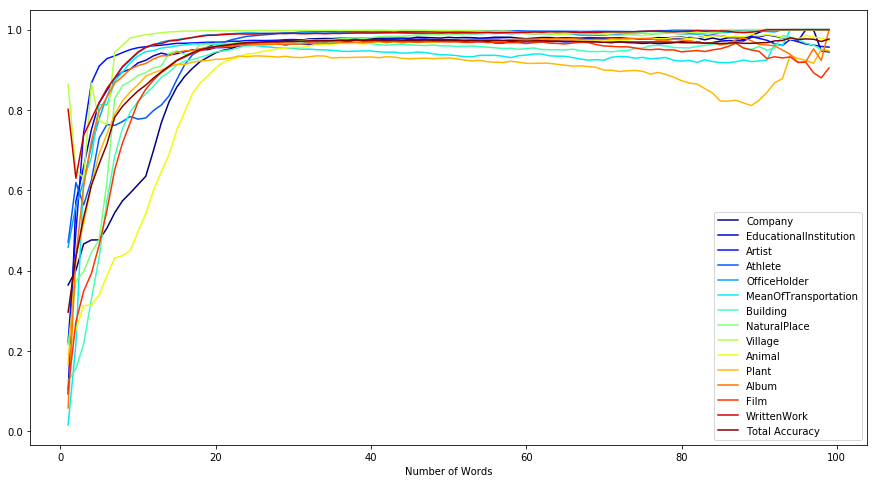

In [48]:
accuracies.plot(x = 'Number of Words', figsize = (15,8), colormap = 'jet')
plt.show()

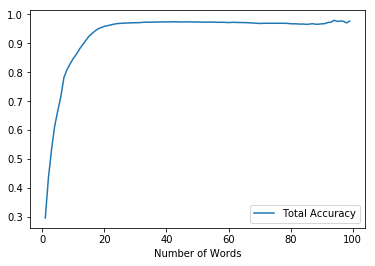

In [49]:
accuracies.plot(x = 'Number of Words', y = 'Total Accuracy')
plt.show()